import stuff

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#save_path = '/content/drive/My Drive/Colab Notebooks/SNN_SRM/W_backup/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/SSNN-BP')

tf.nn.depthwise_conv2d will be used to simulate the SNN with a Spike Response Model. For this, it needs input of shape (batch, 1, in_width, in_channels) and filters of shape (1, filter_width, in_channels, 1). The convolution occurs in the dimension of width - which should correspond to simulation steps 
Describe the model in the following block

In [ ]:
tf.disable_v2_behavior()
seed = 0
rng = np.random.RandomState(seed)
tf.set_random_seed(seed)
np.seterr(all='raise')

# SNN parameters

#num_iter = 101
#max_in_spikes = 101
#max_out_spikes = 51

#num_iter = 201
#max_in_spikes = 201
#max_out_spikes = 101

num_iter = 301
max_in_spikes = 301
max_out_spikes = 151

dataset = 'mnist_784'   # full size 70000
data_size = 30000  # Training + validation data size
data_size_test = 10000  # Test data size

data = fetch_openml(dataset)
X_full = data.data
y_full = np.float32(data.target)
X_full = (X_full - X_full.min()) / (X_full.max()+0.000001 - X_full.min())

num_images = X_full.shape[0]
N = 28 * 28
im_size = 28
num_output = 10

rand_perm = rng.permutation(num_images)
X_full = X_full.to_numpy()
X_full = X_full[rand_perm]
y_full = y_full[rand_perm]

if data_size + data_size_test > X_full.shape[0]:
    data_size = X_full.shape[0] - data_size_test

print("total size: ", X_full.shape[0])
print("train size: ", data_size)
print("test size: ", data_size_test)

X_data = X_full[:data_size]
y_data = y_full[:data_size]

X_test = X_full[-data_size_test:]
y_test = y_full[-data_size_test:]

#Fill out the labels
y_in_train = np.zeros((X_data.shape[0], 1, num_iter, num_output), dtype=np.int8)
y_in_test = np.zeros((X_test.shape[0], 1, num_iter, num_output), dtype=np.int8)

for i in range(X_data.shape[0]):
    label_ind = np.int32(y_data[i])
    spikes = np.random.uniform(size=num_iter)
    spikes[spikes<(max_out_spikes/num_iter)] = 1
    spikes[spikes<1] = 0
    y_in_train[i,0,:,label_ind] = spikes

for i in range(X_test.shape[0]):
    label_ind = np.int32(y_test[i])
    spikes = np.random.uniform(size=num_iter)
    spikes[spikes<(max_out_spikes/num_iter)] = 1
    spikes[spikes<1] = 0
    y_in_test[i,0,:,label_ind] = spikes

Instructions for updating:
non-resource variables are not supported in the long term
/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


total size:  70000
train size:  30000
test size:  10000


Fill out the spike data

In [ ]:
batch_size = 100

X_in_train = np.zeros((X_data.shape[0], 1, num_iter, X_data.shape[1]), dtype=np.int8)
X_in_test = np.zeros((X_test.shape[0], 1, num_iter, X_test.shape[1]), dtype=np.int8)

num_batches = data_size//batch_size
num_batches_test = data_size_test//batch_size
for b in range(num_batches):
  if(b%50==0):
    print("completed: ", b/num_batches)
  batch_data = X_data[b*batch_size:(b+1)*batch_size]*(max_in_spikes/num_iter)
  batch_reshp = np.reshape(batch_data, (batch_size, -1, 1, 1)) #shape=(batch_size, N, 1, 1)
  batch_data_tiled = np.tile(batch_reshp, (1, 1, num_iter, 1)) #shape=(batch_size, N, num_iter, 1)
  batch_data_trans = np.transpose(batch_data_tiled, (0,3,2,1)) #shape=(batch_size, 1, num_iter, N)
  batch_in = np.random.uniform(size=(batch_size, 1, num_iter, N))
  batch_in[batch_in<batch_data_trans] = 1
  batch_in[batch_in<1] = 0
  X_in_train[b*batch_size:(b+1)*batch_size] = batch_in

for b in range(num_batches_test):
  batch_data = X_test[b*batch_size:(b+1)*batch_size]*(max_in_spikes/num_iter)
  batch_reshp = np.reshape(batch_data, (batch_size, -1, 1, 1))
  batch_data_tiled = np.tile(batch_reshp, (1, 1, num_iter, 1))
  batch_data_trans = np.transpose(batch_data_tiled, (0,3,2,1))
  batch_in = np.random.uniform(size=(batch_size, 1, num_iter, N))
  batch_in[batch_in<batch_data_trans] = 1
  batch_in[batch_in<1] = 0
  X_in_test[b*batch_size:(b+1)*batch_size] = batch_in


completed:  0.0
completed:  0.16666666666666666
completed:  0.3333333333333333
completed:  0.5
completed:  0.6666666666666666
completed:  0.8333333333333334


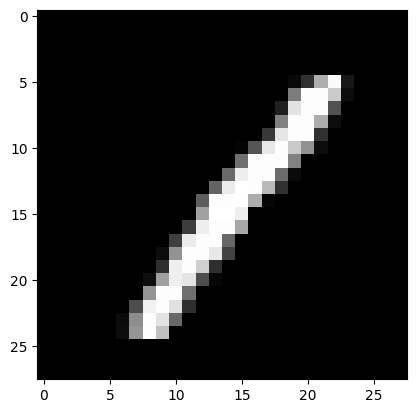

In [ ]:
import matplotlib.pyplot as plt
sample = 500
image = X_data[sample].reshape((28,28))# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
import RPU_SNN as snn

batch_size = 50
num_epochs = 11
lr = 0.005
beta = 0.9
eps = 1e-8
k_size = num_iter
hidden_size = 1280
th_val_h = 5
th_val_y = 5

self_iter = 5
#self_iter = 0

# Initialize Placeholders (X_in, labels, dropout_masks, kernels)
keep_prob1 = tf.placeholder('float', shape=())
keep_prob2 = tf.placeholder('float', shape=())
tf_kernelh = tf.placeholder('float', [1, k_size, hidden_size, 1])
tf_kernelh_b = tf.placeholder('float', [1, k_size, hidden_size, 1])
tf_kernely = tf.placeholder('float', [1, k_size, num_output, 1])
tf_kernely_b = tf.placeholder('float', [1, k_size, num_output, 1])
dropout_mask1 = tf.placeholder('float', [batch_size,1,num_iter,N])
dropout_mask2 = tf.placeholder('float', [batch_size,1,num_iter,hidden_size])
X_pl = tf.placeholder('float', [batch_size, 1, num_iter, N])
s_label = tf.placeholder('float', [batch_size, 1, num_iter, num_output])

# Initialize Weights (He initialization)
W1 = tf.Variable(tf.random_normal((N,hidden_size), stddev=np.sqrt(4/N)), trainable=False)
W2 = tf.Variable(tf.random_normal((hidden_size,num_output), stddev=np.sqrt(4/hidden_size)), trainable=False)
W_inh = tf.Variable(tf.matrix_set_diag(1.0*tf.ones((num_output, num_output)), tf.zeros(num_output)), trainable=False)
W1mt = tf.Variable(tf.zeros((N,hidden_size)), trainable=False)
W2mt = tf.Variable(tf.zeros((hidden_size, num_output)), trainable=False)

W1mt_acc = tf.Variable(W1mt)
W2mt_acc = tf.Variable(W2mt)

# MOMENTUM
#W1_acc = W1
#W2_acc = W2

# NESTEROV ACCELERATED GRADIENT
W1_acc = W1 + beta*W1mt_acc
W2_acc = W2 + beta*W2mt_acc

X_masked, s_out_h_acc = snn.forward_pass(X_pl, dropout_mask1, W1_acc, th_val_h, tf_kernelh)
s_out_h_masked, s_out_y_acc = snn.y_WTA(s_out_h_acc, dropout_mask2, W2_acc, th_val_y, tf_kernely, W_inh, self_iter)

del_p_y, del_m_y, W2gt_orig = snn.finalW_update(s_out_y_acc, s_out_h_masked, s_label, th_val_y, tf_kernely_b)
del_p_h, del_m_h, W1gt_orig = snn.innerW_update(s_out_h_masked, X_masked, del_p_y, del_m_y, W2_acc, th_val_h, tf_kernelh_b)

W1mt_acc = beta*W1mt_acc + lr*W1gt_orig
W2mt_acc = beta*W2mt_acc + lr*W2gt_orig

new_W1 = W1.assign_add(W1mt_acc)
new_W2 = W2.assign_add(W2mt_acc)

# define the SRM kernels here
tau = num_iter/10
kernelh = snn.gen_kernel(k_size, hidden_size, tau)
kernely = snn.gen_kernel(k_size, num_output, tau)

tau = num_iter/100
kernely_b = snn.gen_kernel(k_size, num_output, tau)
kernelh_b = snn.gen_kernel(k_size, hidden_size, tau)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use `tf.cast` instead.


Run the training

In [ ]:
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
pr_fq = 2
all_test_accuracies = []
all_test_accuracies_acc = []

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(num_epochs):
        num_batches = data_size//batch_size
        print("epoch : ", e)
        accs = []
        rand_perm = rng.permutation(data_size)
        X_in_train = X_in_train[rand_perm]
        y_in_train = y_in_train[rand_perm]
        pick_dropout_prob = np.random.uniform()
        dropout_prob2 = 0.3
        dropout_prob1 = 0.2
        for b in range(num_batches):
            #generate dropout mask
            p = np.random.uniform(size=N)
            p[p<dropout_prob1] = 0
            p[p>0] = 1
            ps_arr1 = np.zeros((batch_size, 1, num_iter, N))
            ps_arr1[:, :, :, p>0] = 1

            p = np.random.uniform(size=hidden_size)
            p[p<dropout_prob2] = 0
            p[p>0] = 1
            ps_arr2 = np.zeros((batch_size, 1, num_iter, hidden_size))
            ps_arr2[:, :, :, p>0] = 1
            
            in_batch = np.float64(X_in_train[b*batch_size:(b+1)*batch_size])
            label_batch = np.float64(y_in_train[b*batch_size:(b+1)*batch_size])
            feeds = {X_pl: in_batch, s_label: label_batch, tf_kernelh: kernelh, tf_kernelh_b: kernelh_b, tf_kernely: kernely, tf_kernely_b: kernely_b, dropout_mask1: ps_arr1, dropout_mask2: ps_arr2, keep_prob1: 1-dropout_prob1, keep_prob2: 1-dropout_prob2}
            out_y,_,_ = sess.run([s_out_y_acc, new_W1, new_W2], feed_dict=feeds)

            out_means = np.mean(out_y, axis=(1,2))
            label_means = np.mean(label_batch, axis=(1,2))
            out_labels = np.argmax(out_means, axis=1)
            orig_labels = np.argmax(label_means, axis=1)
            batch_acc = np.mean(np.float32(out_labels==orig_labels))
            accs.append(batch_acc)
        if e%pr_fq == 0:
            test_accs = []
            test_accs_acc = []
            num_test_batches = data_size_test//batch_size
            for c in range(num_test_batches):
                in_batch = np.float64(X_in_test[c*batch_size:(c+1)*batch_size])
                label_batch = np.float64(y_in_test[c*batch_size:(c+1)*batch_size])
                ps_arr_test1 = np.ones((batch_size, 1, num_iter, N))
                ps_arr_test2 = np.ones((batch_size, 1, num_iter, hidden_size))
                feeds = {X_pl: in_batch, tf_kernelh: kernelh, tf_kernely: kernely, dropout_mask1: ps_arr_test1, dropout_mask2: ps_arr_test2, keep_prob1: 1, keep_prob2: 1}
                out_h,out_y = sess.run([s_out_h_acc, s_out_y_acc], feed_dict=feeds)
                
                out_means = np.mean(out_y, axis=(1,2))
                label_means = np.mean(label_batch, axis=(1,2))
                out_labels = np.argmax(out_means, axis=1)
                orig_labels = np.argmax(label_means, axis=1)
                batch_acc = np.mean(np.float32(out_labels==orig_labels))
                test_accs.append(batch_acc)
            test_accuracy = np.mean(batch_size*np.array(test_accs))/batch_size
            all_test_accuracies.append(test_accuracy)
            print("test accuracy : ", test_accuracy)
        epoch_accuracy = np.mean(batch_size*np.array(accs))/batch_size
        print("accuracy : ", epoch_accuracy)
    final_W1 = W1.eval()
    final_W2 = W2.eval()

epoch :  0
test accuracy :  0.8487000274658203
accuracy :  0.7075333404541015
epoch :  1
accuracy :  0.8479666900634766
epoch :  2
test accuracy :  0.8988999938964843
accuracy :  0.8674333190917969
epoch :  3
accuracy :  0.8775333404541016
epoch :  4
test accuracy :  0.9120999908447266
accuracy :  0.8909666442871094
epoch :  5
accuracy :  0.8973666381835937
epoch :  6
test accuracy :  0.9216000366210938
accuracy :  0.9027333068847656
epoch :  7
accuracy :  0.9072000122070313
epoch :  8
test accuracy :  0.9298000335693359
accuracy :  0.9117333221435547
epoch :  9
accuracy :  0.9162666320800781
epoch :  10
test accuracy :  0.9366999816894531
accuracy :  0.9199333190917969


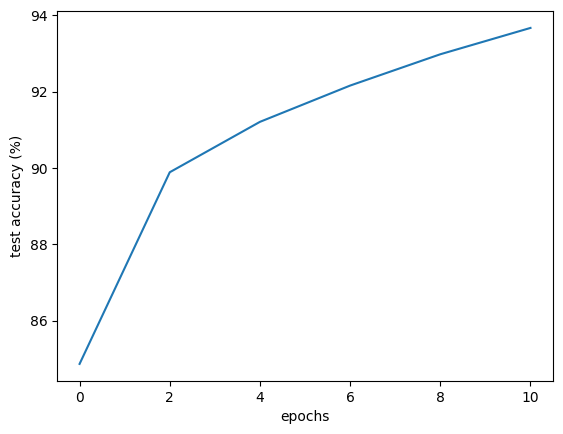

n_iter :  301
max test acc : 0.9366999816894531
last test acc : 0.9366999816894531
H1 :  1280
self iter -  5
dropout 1 -  0.2
dropout 2 -  0.3
raw test accuracies
[0.8487000274658203, 0.8988999938964843, 0.9120999908447266, 0.9216000366210938, 0.9298000335693359, 0.9366999816894531]
running avg test accuracies
[0.84870003 0.87380001 0.88656667 0.89532501 0.90222002 0.90796668]
running std test accuracies
[0.         0.02509998 0.02731266 0.02810003 0.02866799 0.02915474]


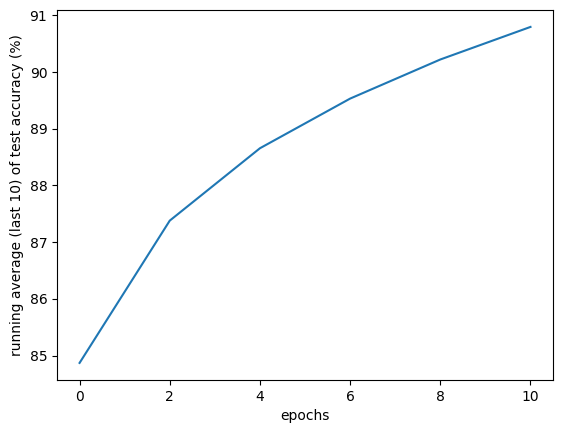

In [ ]:
plt.figure()
plt.plot(np.arange(0,2*len(all_test_accuracies),2), 100*np.array(all_test_accuracies))
plt.xlabel('epochs')
plt.ylabel('test accuracy (%)')
plt.show()
print("n_iter : ", num_iter)
print("max test acc : " + str(np.max(np.array(all_test_accuracies))))
print("last test acc : " + str(all_test_accuracies[-1]))
print("H1 : ", hidden_size)
#print(all_test_accuracies)
running_avg_acc = np.zeros_like(np.array(all_test_accuracies))
running_std_acc = np.zeros_like(np.array(all_test_accuracies))
for i in range(len(all_test_accuracies)):
    if i<9:
        running_avg_acc[i] = np.mean(np.array(all_test_accuracies)[0:i+1])
        running_std_acc[i] = np.std(np.array(all_test_accuracies)[0:i+1])
    else:
        running_avg_acc[i] = np.mean(np.array(all_test_accuracies)[i-9:i+1])
        running_std_acc[i] = np.std(np.array(all_test_accuracies)[i-9:i+1])

plt.figure()
plt.plot(np.arange(0,2*len(all_test_accuracies),2), 100*running_avg_acc)
plt.xlabel('epochs')
plt.ylabel('running average (last 10) of test accuracy (%)')

print('self iter - ', self_iter)
print('dropout 1 - ', dropout_prob1)
print('dropout 2 - ', dropout_prob2)
print('raw test accuracies')
print(all_test_accuracies)
print('running avg test accuracies')
print(running_avg_acc)
print('running std test accuracies')
print(running_std_acc)

In [ ]:
print("number of input  spikes per sample : ", np.sum(in_batch)/batch_size)
print("number of hidden spikes per sample : ", np.sum(out_h)/batch_size)
print("number of output spikes per sample : ", np.sum(out_y)/batch_size)
print("number of target spikes per sample : ", np.sum(label_batch)/batch_size)

number of input  spikes per sample :  29524.08
number of hidden spikes per sample :  104371.62
number of output spikes per sample :  265.44
number of target spikes per sample :  151.32
